In [189]:
import requests
import yfinance as yf
import pandas as pd
import time
import tqdm
from pandas_datareader import data
import os
import warnings
warnings.filterwarnings('ignore')

## Get book value data

In [75]:
url = 'https://www.slickcharts.com/sp500/'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

dfs = pd.read_html(r.text)

In [128]:
def get_book_value(dfs):
    empty_ticks = {'No data':[],'No equity':[]}
    output_dfs = []

    for symbol in tqdm.tqdm(dfs[0]['Symbol'].values):
        ticker = yf.Ticker(symbol)
        bal = ticker.quarterly_balance_sheet

        if len(bal.index) == 0:
            empty_ticks['No data'].append(symbol)
        else:    
            bal.columns = [str(col.year) + '-' + str(col.quarter) for col in bal.columns]
            equity = bal[bal.index.isin(['Common Stock','Total Stockholder Equity','Equity'])]
            if len(equity.index) == 0:
                empty_ticks['No equity'].append(symbol)
            else:
                equity['Ticker'] = symbol
                output_dfs.append(equity)
                time.sleep(3)
    return outpout_dfs, empty_ticks

In [129]:
for df in output_dfs:
    if os.path.isfile('book_values.csv'):
        HEADER=False
    else:
        HEADER=True
    df.to_csv('book_values.csv',mode='a',header=HEADER)

In [133]:
if os.path.isfile('book_values.csv'):
    book_df = pd.read_csv('book_values.csv')
else:  
    outpout_dfs, empty_ticks = get_book_value(dfs)
    for df in output_dfs:
        if os.path.isfile('book_values.csv'):
            HEADER=False
        else:
            HEADER=True
        df.to_csv('book_values.csv',mode='a',header=HEADER)
    book_df = pd.read_csv('book_values.csv')

## Get market cap

In [ ]:
tickers = dfs[0]['Symbol'].values

In [135]:
def get_market_cap(tickers):
    caps = {}
    notfound = {}
    for tick in tqdm.tqdm(tickers):
        try:
            cap = data.get_quote_yahoo(tick)['marketCap']
            caps[tick] = cap[0]
        except KeyError as e:
            notfound[tick] = e
            pass
    return caps, notfound

In [146]:
if os.path.isfile('book_values.csv'):
    caps_df = pd.read_csv('cap_values.csv').set_index('Unnamed: 0')
else:  
    caps, empty_ticks = get_book_value(dfs)
    caps_df = pd.DataFrame(index=caps.keys(), data=caps.values(), columns={'cap'}).set_index('Unnamed: 0')

## Calculate Tobin Q

In [149]:
book_df = book_df.set_index('Ticker').rename(columns={'Unnamed: 0':'Asset type'})

In [147]:
caps_df.index.name = 'Ticker'
caps_df

,cap
Ticker,
AAPL,2794502225920
MSFT,2314409869312
AMZN,1460363067392
GOOGL,1770370629632
GOOG,1769346170880
...,...
DISCA,13502291968
GPS,6635371520
UAA,7990502912


In [154]:
tobin = book_df.join(caps_df,on='Ticker')

In [163]:
tobin['TobinQ'] = tobin['cap']/tobin['2021-3']

In [172]:
tobin_stock = tobin.loc[tobin['Asset type']=='Common Stock']
tobin_eq = tobin.loc[tobin['Asset type']=='Total Stockholder Equity']

In [173]:
tobin

,Asset type,2021-3,2021-2,2021-1,2020-4,cap,TobinQ
Ticker,,,,,,,
AAPL,Total Stockholder Equity,6.309000e+10,6.428000e+10,6.917800e+10,6.622400e+10,2.794502e+12,44.293901
AAPL,Common Stock,5.736500e+10,5.498900e+10,5.420300e+10,5.174400e+10,2.794502e+12,48.714412
MSFT,Total Stockholder Equity,1.519780e+11,1.419880e+11,1.345050e+11,1.302360e+11,2.314410e+12,15.228585
MSFT,Common Stock,8.375100e+10,8.311100e+10,8.230800e+10,8.189600e+10,2.314410e+12,27.634415
AMZN,Total Stockholder Equity,1.205640e+11,1.148030e+11,1.033200e+11,9.340400e+10,1.460363e+12,12.112762
...,...,...,...,...,...,...,...
UAA,Common Stock,1.580000e+05,1.550000e+05,1.510000e+05,1.500000e+05,7.990503e+09,50572.803241
UA,Total Stockholder Equity,1.977749e+09,1.846710e+09,1.770199e+09,1.675993e+09,8.036860e+09,4.063640
UA,Common Stock,1.580000e+05,1.550000e+05,1.510000e+05,1.500000e+05,8.036860e+09,50866.205165


<AxesSubplot:xlabel='Ticker'>

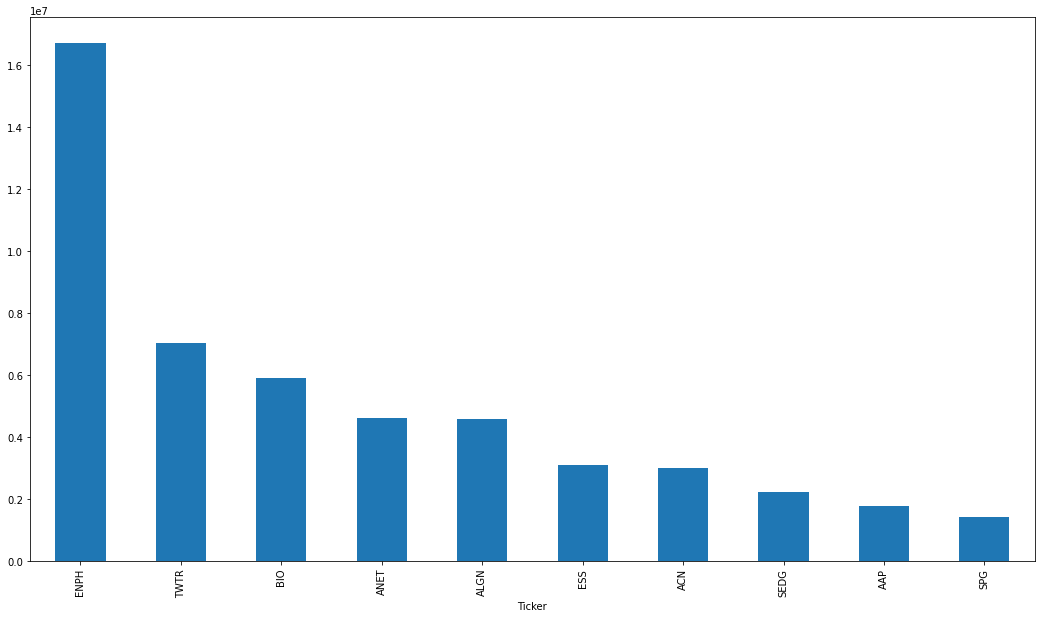

In [185]:
tobin_stock['TobinQ'].sort_values(ascending=False)[:10].plot(kind='bar',figsize=(18,10))

<AxesSubplot:xlabel='Ticker'>

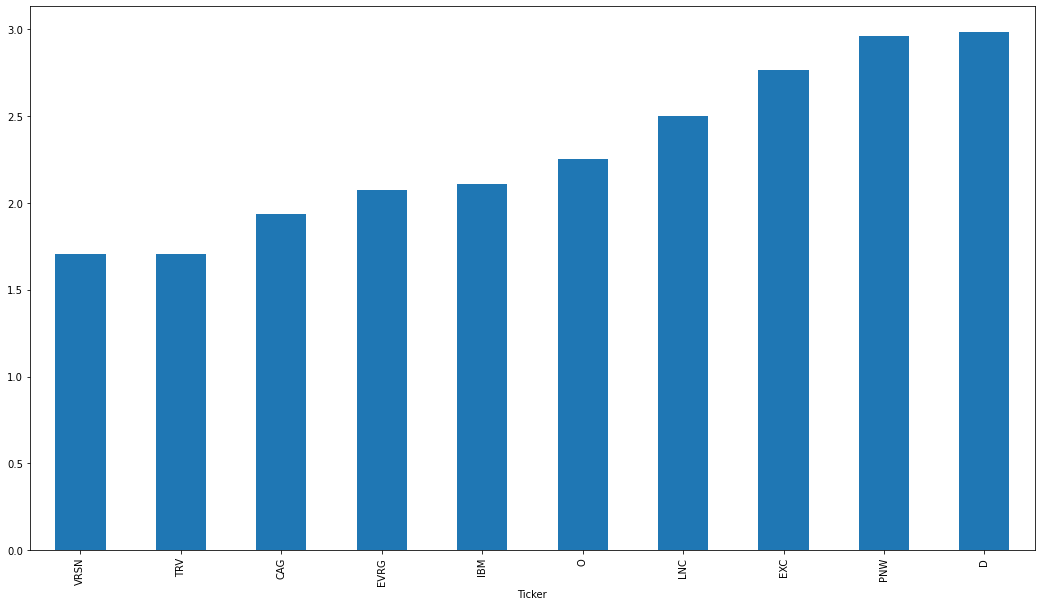

In [187]:
tobin_stock['TobinQ'].sort_values(ascending=True)[:10].plot(kind='bar',figsize=(18,10))

<AxesSubplot:xlabel='Ticker'>

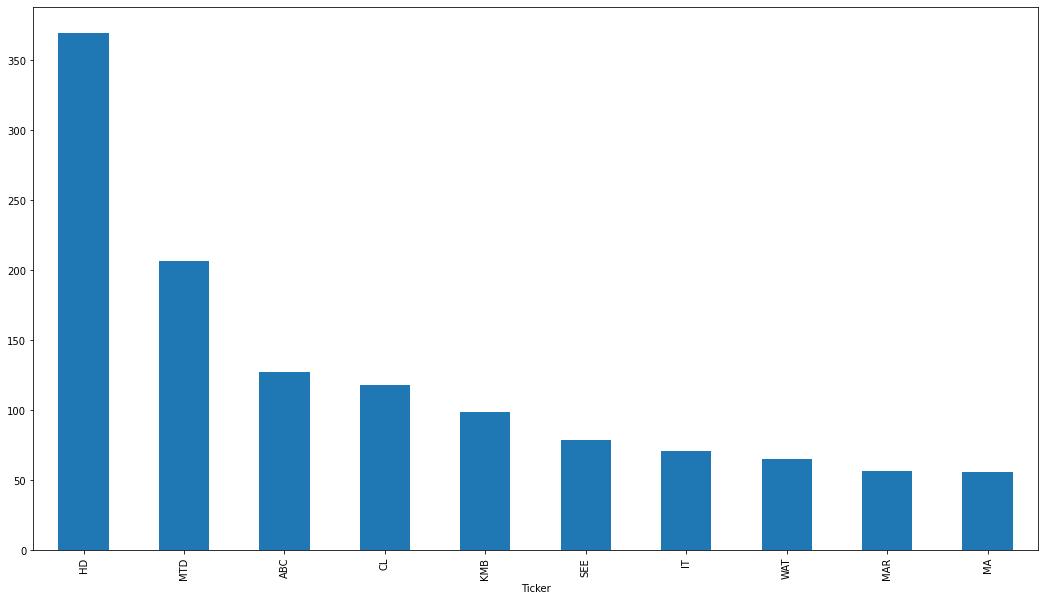

In [186]:
tobin_eq['TobinQ'].sort_values(ascending=False)[:10].plot(kind='bar',figsize=(18,10))

<AxesSubplot:xlabel='Ticker'>

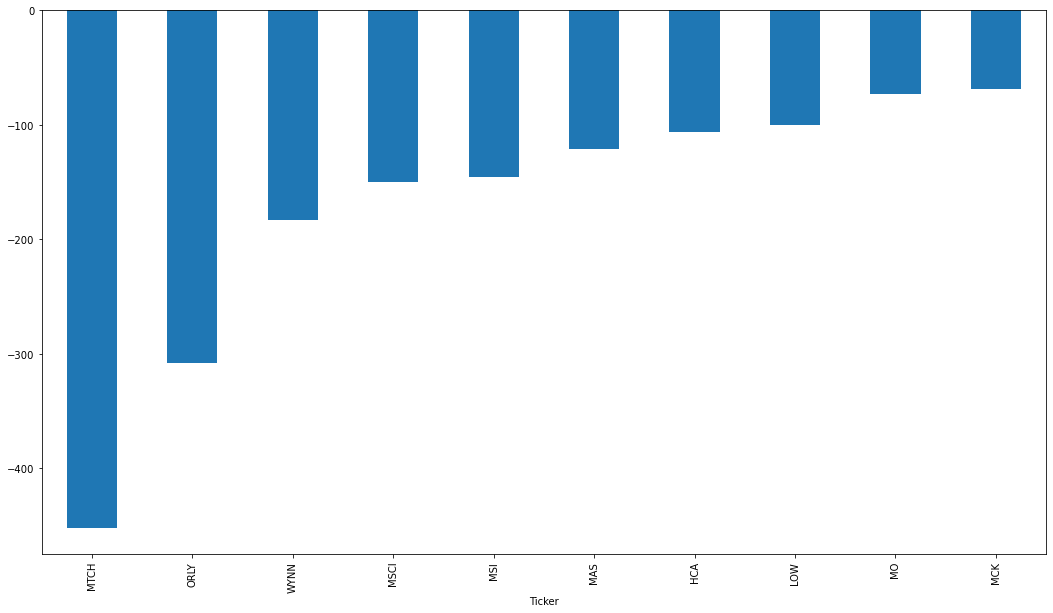

In [188]:
tobin_eq['TobinQ'].sort_values(ascending=True)[:10].plot(kind='bar',figsize=(18,10))

<AxesSubplot:xlabel='Ticker'>

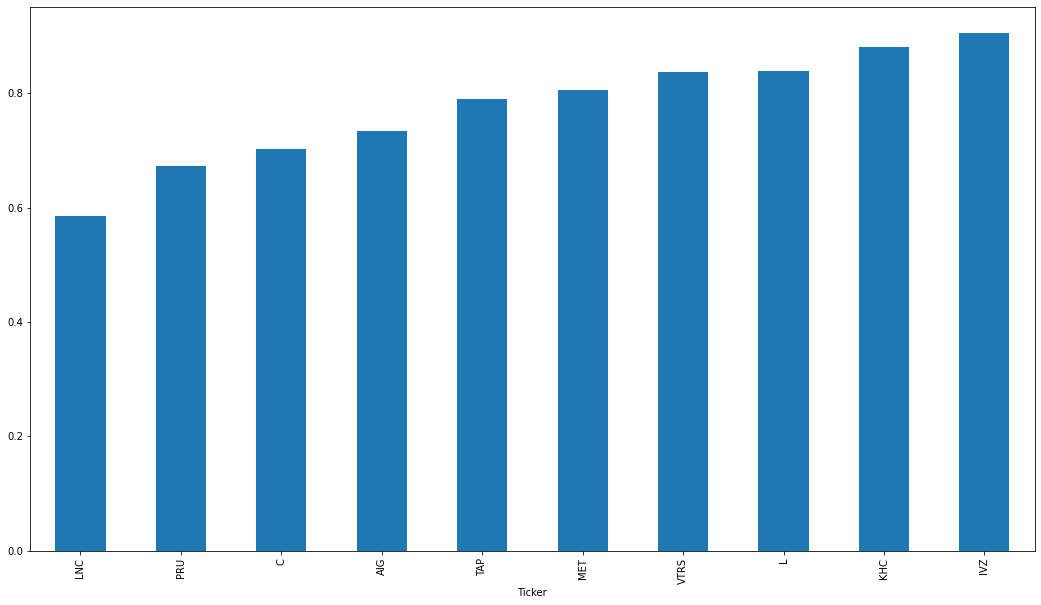

In [216]:
tobin_eq[tobin_eq['TobinQ']>0]['TobinQ'].sort_values(ascending=True)[:10].plot(kind='bar',figsize=(18,10))

In [195]:
tobin_eq.sort_values(by='TobinQ')

,Asset type,2021-3,2021-2,2021-1,2020-4,cap,TobinQ
Ticker,,,,,,,
MTCH,Total Stockholder Equity,-68352000.000,-142245000.000,-1214591000.000,-1177667000.000,30918543360.000,-452.343
ORLY,Total Stockholder Equity,-140853000.000,217694000.000,-6977000.000,140258000.000,43359350784.000,-307.834
WYNN,Total Stockholder Equity,-53238000.000,102752000.000,233683000.000,-351997000.000,9730307072.000,-182.770
MSCI,Total Stockholder Equity,-280025000.000,-367807000.000,-481582000.000,-443234000.000,41893642240.000,-149.607
MSI,Total Stockholder Equity,-263000000.000,-358000000.000,-496000000.000,-558000000.000,38359883776.000,-145.855
...,...,...,...,...,...,...,...
ABC,Total Stockholder Equity,223354000.000,37962000.000,-281756000.000,-697222000.000,28472594432.000,127.477
MTD,Total Stockholder Equity,159171000.000,191424000.000,202643000.000,282675000.000,32881733632.000,206.581
HD,Total Stockholder Equity,1035000000.000,2069000000.000,1748000000.000,3299000000.000,382755733504.000,369.812


<AxesSubplot:ylabel='Frequency'>

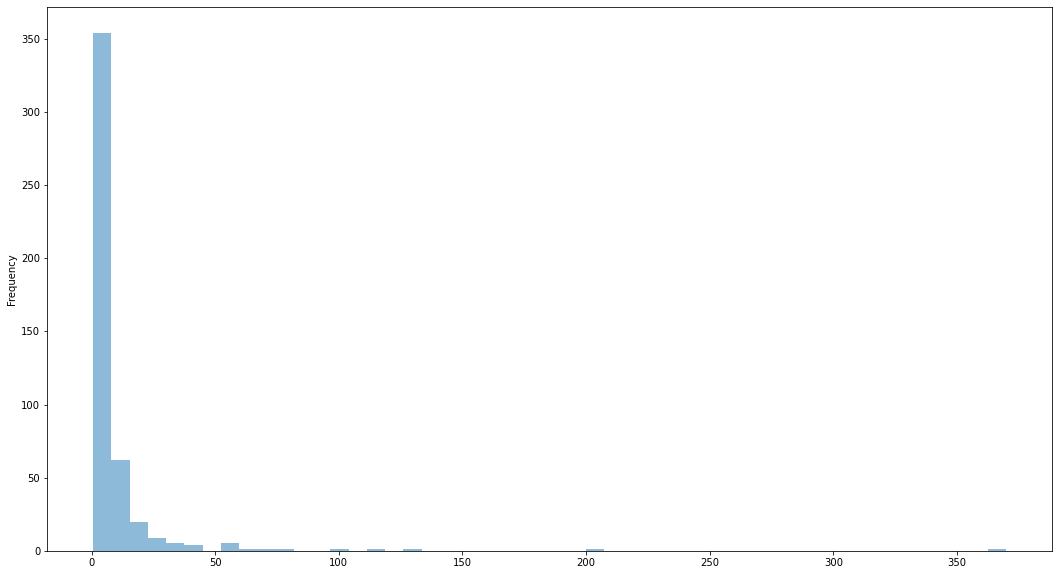

In [215]:
tobin_eq[tobin_eq['TobinQ']>0]['TobinQ'].sort_values(ascending=True).plot.hist(bins=50,alpha=0.5,figsize=(18, 10))

<AxesSubplot:ylabel='Frequency'>

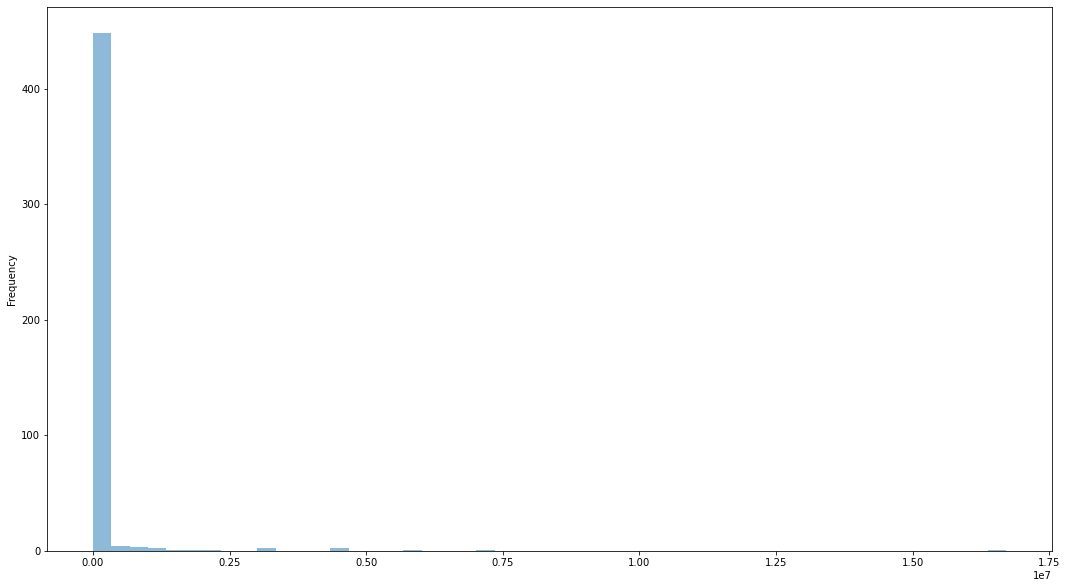

In [214]:
tobin_stock['TobinQ'].sort_values(ascending=True).plot.hist(bins=50,alpha=0.5,figsize=(18, 10)) 

In [202]:
tobin_eq['cap'].sum()/tobin_eq['2021-3'].sum()

4.738456869960177

In [204]:
tobin_stock['cap'].sum()/tobin_stock['2021-3'].sum()

36.46498645713531

In [208]:
tobin_eq['cap'].isnull().value_counts()

False    495
True       2
Name: cap, dtype: int64